In [1]:
import numpy as np
busy_periods_remainsize = np.load(
                "/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_test/0/ns3/period_remainsize_topology_flows_dctcp_t100000000.npy",
                allow_pickle=True,
            )
print(busy_periods_remainsize)

FileNotFoundError: [Errno 2] No such file or directory: '/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data_test/0/ns3/period_remainsize_topology_flows_dctcp_t100000000.npy'

In [1]:
import numpy as np
from util.plot import plot_cdf,color_list
from util.consts import balance_len_bins_test,balance_len_bins_test_label,balance_size_bins,balance_size_bins_label,get_base_delay_path,get_base_delay_transmission
import matplotlib.pyplot as plt
import json
import glob
import os
from collections import defaultdict

topo_type_ori="_topology_flows_dctcp"
lr=10
rotation_angle=30
np.random.seed(0)
balance_len_bins=balance_len_bins_test
balance_len_bins_label=balance_len_bins_test_label

In [2]:
def compute_active_flows(fats, fcts):
    num_flows = len(fats)
    result = np.zeros(num_flows, dtype=int)
    
    finish_times = fats + fcts
    
    for i in range(num_flows):
        flow_start = fats[i]
        flow_end = finish_times[i]
        
        active_flows = np.where((fats < flow_end) & (finish_times > flow_start) & (np.arange(num_flows) != i))[0]
        result[i] = len(active_flows)
    
    return result

def count_events(fats, fcts):
    num_flows = len(fats)
    result = np.zeros(num_flows, dtype=int)
    
    finish_times = fats + fcts
    
    events = np.concatenate((fats, finish_times))
    
    for i in range(num_flows):
        flow_start = fats[i]
        flow_end = finish_times[i]
        
        num_events = np.sum((events >= flow_start) & (events <= flow_end))
        result[i] = num_events
    
    return result


In [4]:

dir_input_synthetic="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/data"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                'topo_256_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'topo_256_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'topo_256_link_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'topo_256_flowsim_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'topo_256_flowsim_input_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps',
                ]
version_id_list=[
    [0],[0],[0],[0],[0]
]

flow_size_threshold_dict={
    "100m": 100000000,
}
title_str_list = ["flowSim","m4","m4-link","m4-flowsim-diff","m4-flowsim-feat"]
main_title_list=['train-balance','test-balance','empirical-balance']
metric_label_list=["L1 Loss", "Relative error (%)"]

fig_index=0
res_total_per_flow_per_data=[]
size_total_per_flow_per_data=[]
rank_total_per_flow_per_data=[]
len_group_total_per_flow_per_data=[]
res_total_per_seg_per_data=[]

for version_id_test in [0,1,2]:
    res_total_per_flow=[]
    size_total_per_flow=[]
    rank_total_per_flow=[]
    len_group_total_per_flow=[]
    
    res_total_per_seg=[]
    
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            data_list_test=[]
            # if version_id_test==0:
            #     f = open(f"{dir_train}/data_list.json", "r")
            #     data_list = json.loads(f.read())
            #     data_list_test=data_list["test"]
            #     dir_input=dir_input_synthetic
            # else:
            #     data_list_test=[]
            #     dir_input=dir_input_synthetic+"_empirical"
            #     target_path=f'{dir_train}/test/version_{version_id_test}/'
            if version_id_test==0 or version_id_test==1:
                shard_list=np.arange(1000)
                dir_input=dir_input_synthetic
            else:
                shard_list=np.arange(100)
                dir_input=dir_input_synthetic+"_empirical"
            target_path=f'{dir_train}/test/version_{version_id_test}/'
            for shard in shard_list:
                for n_flows in [40000]:
                    for n_hosts in [32]:
                        src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                        topo_type_cur = topo_type_ori
                        spec = f"{shard}/ns3"
                        # statss = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                        # print(statss.item())
                        # size_distribution_list=["cachefollower-all","hadoop-all","webserver-all"]
                        # if statss.item().get("size_dist_candidate") != 'webserver-all': continue
                        # if float(statss.item().get("load_bottleneck_target")) > 0.8: continue
                        # if float(statss.item().get("ias_sigma_candidate")) > 1.5: continue
                        
                        for sample in [0]:
                            pattern=f"{dir_train}test/version_{version_id_test}/{spec}{topo_type_cur}_{src_dst_pair_target_str}_seg*"
                            matching_directories = [d for d in glob.glob(pattern) if os.path.isdir(d)]
                            for matching_directory in matching_directories:
                                segment_id=matching_directory.split("_seg")[-1]
                                data_list_test.append(
                                    (spec, (0, n_hosts - 1), topo_type_cur, int(segment_id), None)
                                )
        
            if len(data_list_test)>500:
                data_list_test_idx=np.random.choice(len(data_list_test),500, replace=False)
                data_list_test=[data_list_test[i] for i in data_list_test_idx]
            len_tracks=len(data_list_test)
            print(f"{program_name} loads {len_tracks} tracks")
            res_per_flow=[]
            size_per_flow=[]
            rank_per_flow=[]
            len_group_per_flow=[]
            
            res_per_seg=[]
            num_flows_to_gt=[]
            # flow_size_threshold=int(program_name.split("_")[1])
            # flow_size_threshold=flow_size_threshold_dict[program_name.split("_")[1]]
            flow_size_threshold=100000000
            for spec, src_dst_pair_target, topo_type, segment_id, _ in data_list_test:
                src_dst_pair_target_str = "_".join([str(x) for x in src_dst_pair_target])+f"_seg{segment_id}"
                
                dir_input_tmp=f"{dir_input}/{spec}"
                
                busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}_t{flow_size_threshold}.npy", allow_pickle=True)
                busy_periods_time = np.load(
                    f"{dir_input_tmp}/period_time{topo_type}_t{flow_size_threshold}.npy"
                )
                fid = np.array(busy_periods[segment_id])
                fid = np.sort(fid)
                # fid=np.arange(int(busy_period[0]),int(busy_period[1])+1)
                period_start_time, period_end_time = busy_periods_time[segment_id]
                assert np.all(fid[:-1] <= fid[1:])
                
                # fid_ori = np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
                sizes = np.load(f"{dir_input_tmp}/fsize.npy")[fid]
                fats = np.load(f"{dir_input_tmp}/fat.npy")[fid]
                # fcts_flowsim = np.load(f"{dir_input_tmp}/fct_flowsim.npy")[fid]
                fcts=np.load(f"{dir_input_tmp}/fct{topo_type}.npy")[fid]
                fcts_i=np.load(f"{dir_input_tmp}/fct_i{topo_type}.npy")[fid]
                gt=np.divide(fcts, fcts_i)
                # fcts=fcts_flowsim
                # fcts_i=i_fcts_flowsim
                # gt=np.divide(fcts, fcts_i)
                
                # fid_rank=fid-np.min(fid)
                # fid_rank=np.arange(len(fid))
                fid_rank = compute_active_flows(fats, fcts)
                # fid_rank = count_events(fats, fcts)
                
                if program_name_idx==0:
                    link_info = np.load(
                        f"{dir_input_tmp}/flow_to_path.npy",
                        allow_pickle=True,
                    )
                    link_info = [link_info[i] for i in fid]
                    n_links_passed = np.array([len(link) for link in link_info])
                    base_delay=get_base_delay_path(sizes,n_links_passed,lr)
                    i_fcts_flowsim = get_base_delay_transmission(sizes,lr) + base_delay
                    fcts_flowsim = np.load(f"{dir_input_tmp}/flowsim_fct.npy")[fid] + base_delay
                    est = np.divide(fcts_flowsim, i_fcts_flowsim)
                else:
                    data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                    est = data['est'].flatten()
                
                flag_flow_incomplete = np.array(fats + fcts > period_end_time)
                
                if len(gt)==1:
                    num_flows_to_gt.append([gt[0],est[0]])
                    
                # gt=gt[~flag_flow_incomplete]
                # est=est[~flag_flow_incomplete]
                # sizes=sizes[~flag_flow_incomplete]
                # fid_rank=fid_rank[~flag_flow_incomplete]
                
                if (len(gt)==0):
                    print(f"empty gt: {spec}{topo_type}_{src_dst_pair_target_str}")
                    continue
                res_tmp=np.abs(gt - est)/gt*100
                
                res_per_flow.extend(res_tmp)
                size_per_flow.extend(sizes)
                rank_per_flow.extend(fid_rank)
                len_group=np.digitize(len(fid), balance_len_bins)
                len_group_per_flow.extend([len_group]*len(sizes))
                assert len(res_tmp)==len(sizes)==len(fid_rank)
                res_per_seg.append([len(fid),np.mean(res_tmp),np.percentile(res_tmp,99)]) 
                
            res_total_per_flow.append(res_per_flow)
            size_total_per_flow.append(size_per_flow)
            rank_total_per_flow.append(rank_per_flow)
            len_group_total_per_flow.append(len_group_per_flow)
            
            res_total_per_seg.append(res_per_seg)
            
    res_total_per_flow=[np.array(x) for x in res_total_per_flow]
    size_total_per_flow=[np.array(x) for x in size_total_per_flow]
    rank_total_per_flow=[np.array(x) for x in rank_total_per_flow]
    len_group_total_per_flow=[np.array(x) for x in len_group_total_per_flow]
    res_total_per_seg=[np.array(x) for x in res_total_per_seg]
    
    res_total_per_flow_per_data.append(res_total_per_flow)
    size_total_per_flow_per_data.append(size_total_per_flow)
    rank_total_per_flow_per_data.append(rank_total_per_flow)
    len_group_total_per_flow_per_data.append(len_group_total_per_flow)
    res_total_per_seg_per_data.append(res_total_per_seg)
    
    

dir_train: /data2/lichenni/output_perflow/topo_256_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
topo_256_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps loads 500 tracks
dir_train: /data2/lichenni/output_perflow/topo_256_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
topo_256_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps loads 500 tracks
dir_train: /data2/lichenni/output_perflow/topo_256_link_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
topo_256_link_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps loads 500 tracks
dir_train: /data2/lichenni/output_perflow/topo_256_flowsim_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
topo_256_flowsim_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps loads 500 tracks
dir_train: /data2/lichenni/output_perflow/topo_256_flowsim_input_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
topo_256_flowsim_input_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps loads 500 tracks
dir_train: /data2/lichenni/output_perflow/topo_256_shard

y_list: [471, 29], x_list: [0, 1]
y_list: [471, 29], x_list: [0, 1]
y_list: [471, 29], x_list: [0, 1]
y_list: [467, 33], x_list: [0, 1]
y_list: [467, 33], x_list: [0, 1]
y_list: [471, 29], x_list: [0, 1]
y_list: [471, 29], x_list: [0, 1]
y_list: [472, 28], x_list: [0, 1]
y_list: [472, 28], x_list: [0, 1]
y_list: [472, 28], x_list: [0, 1]


/tmp/ipykernel_1251658/3192236575.py:178: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(fig_index,figsize=(6, 3))


y_list: [470, 30], x_list: [0, 1]
y_list: [470, 30], x_list: [0, 1]
y_list: [470, 30], x_list: [0, 1]
y_list: [470, 30], x_list: [0, 1]
y_list: [470, 30], x_list: [0, 1]


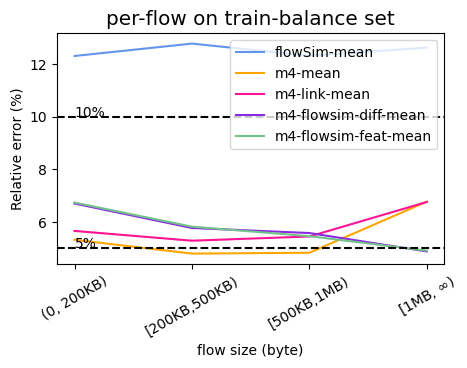

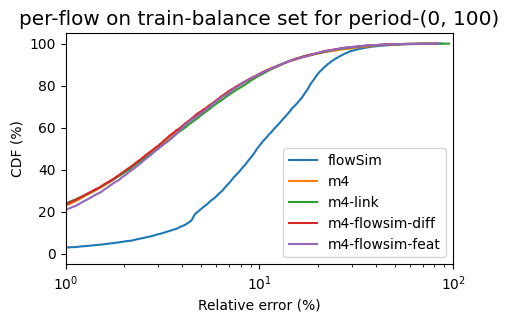

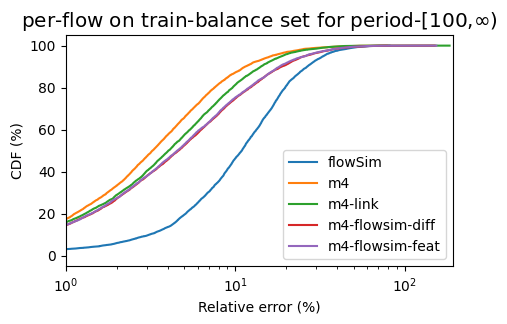

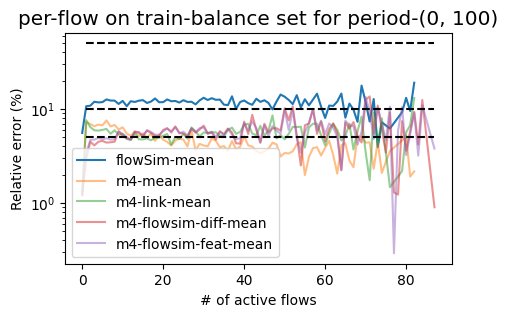

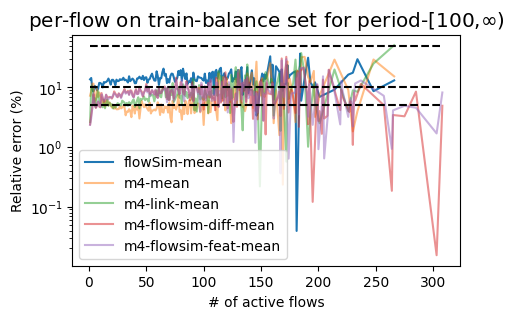

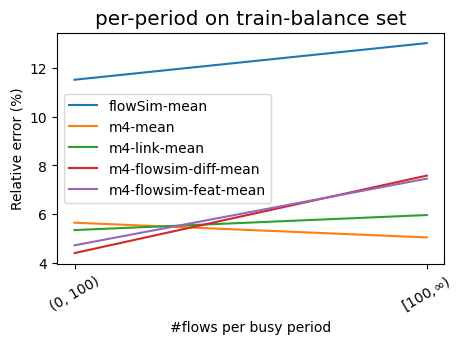

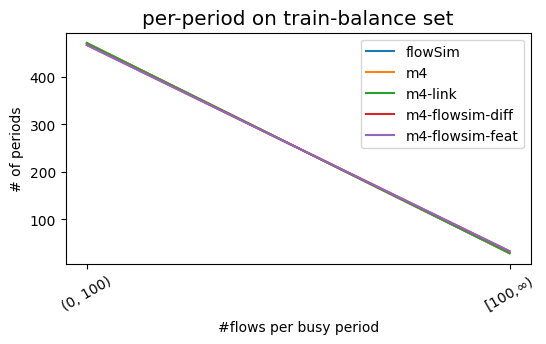

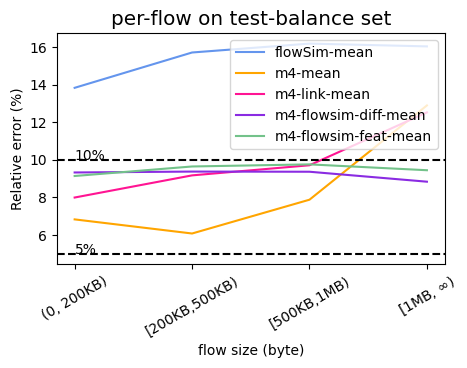

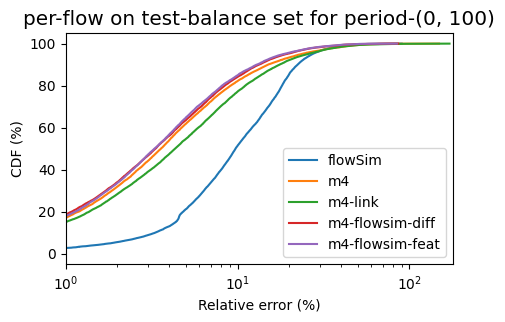

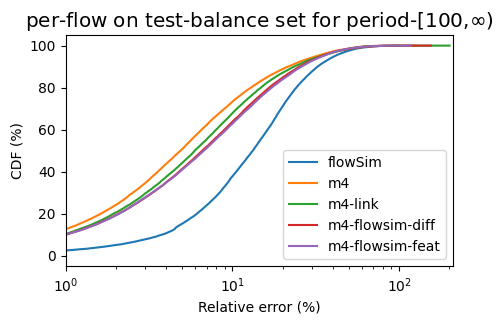

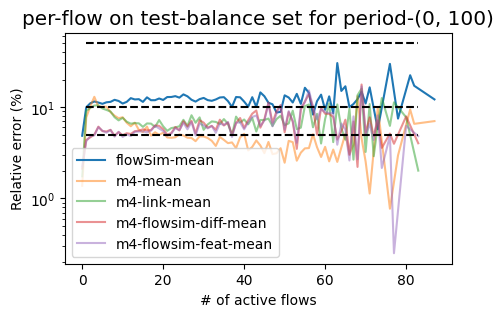

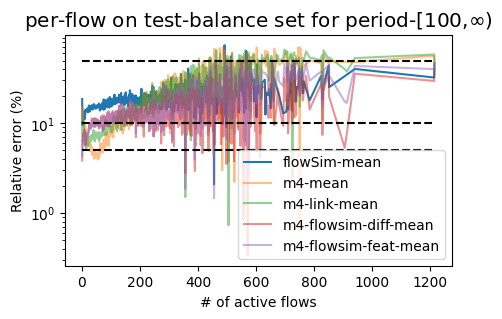

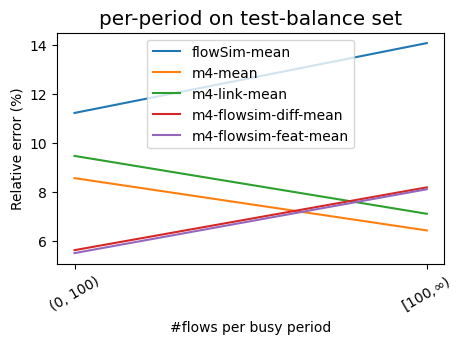

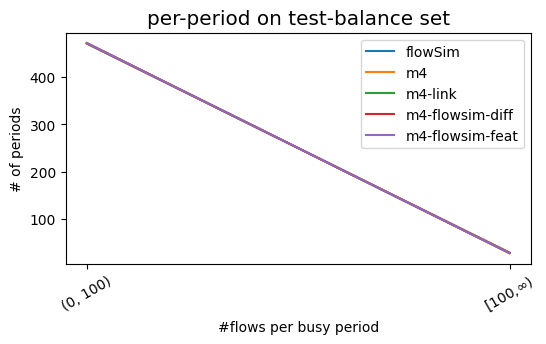

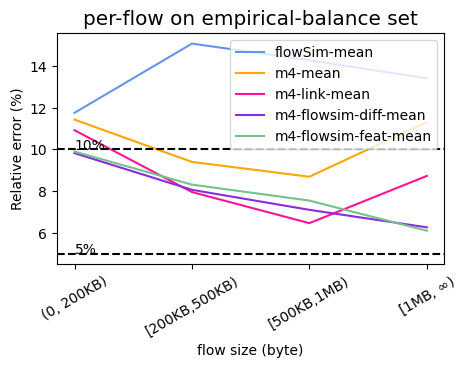

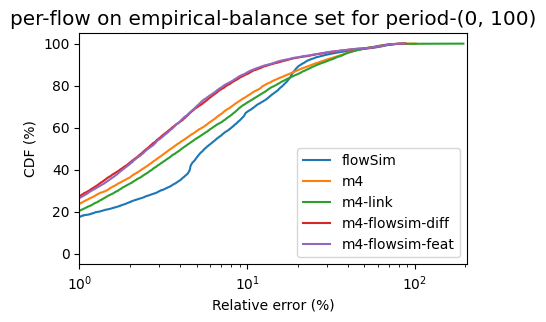

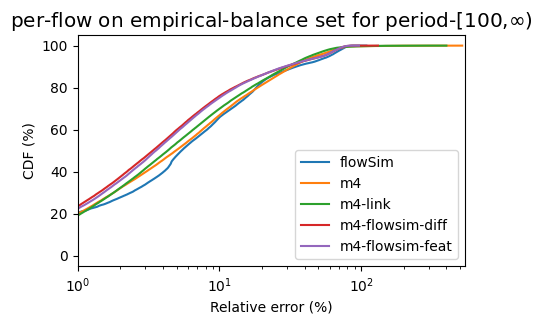

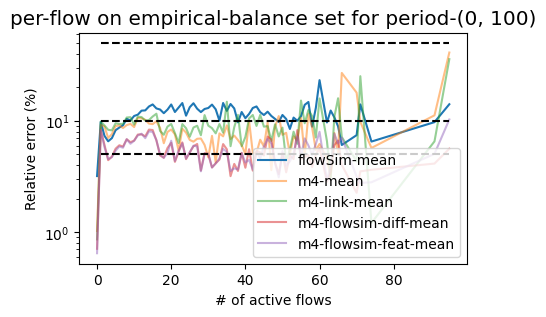

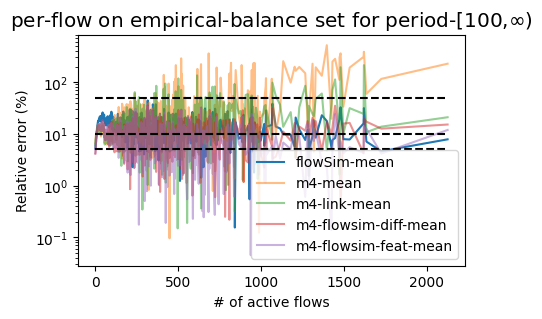

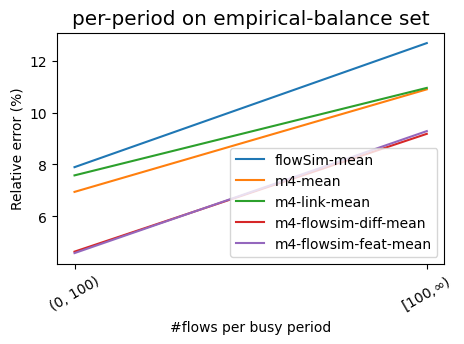

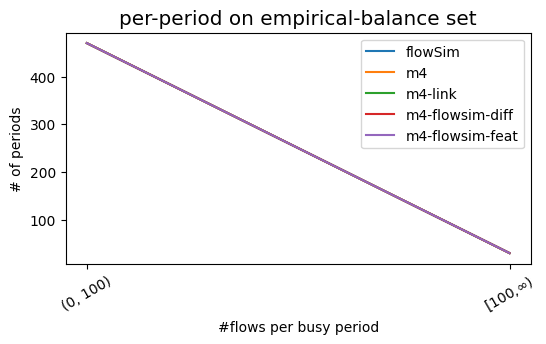

In [10]:
for version_id_test in [0,1,2]:
    res_total_per_flow=res_total_per_flow_per_data[version_id_test]
    size_total_per_flow=size_total_per_flow_per_data[version_id_test]
    rank_total_per_flow=rank_total_per_flow_per_data[version_id_test]
    len_group_total_per_flow=len_group_total_per_flow_per_data[version_id_test]
    res_total_per_seg=res_total_per_seg_per_data[version_id_test]
                                                 
    enable_debug=False
    # for metric_idx in range(len(metric_label_list)):
    for metric_idx in [1]:
        # relationship between flow size and estimation error
        fsize_total_per_flow=[np.digitize(x, balance_size_bins) for x in size_total_per_flow]
        
        if enable_debug:
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                plt.scatter(fsize_total_per_flow[j],res_total_per_flow[j],label=title_str_list[j],s=1)
            plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle)
            plt.legend()
            # plt.xscale('log')
            plt.xlabel("flow size")
            plt.ylabel(f"{metric_label_list[1]}")
            fig_index+=1
        
        # relationship between flow size and mean/p99 estimation error
        x_total=[]
        for j in range(len(program_name_list)):
            x=[]
            for i in range(len(balance_size_bins_label)):
                tmp=res_total_per_flow[j][fsize_total_per_flow[j]==i]
                x.append([np.mean(tmp),np.percentile(tmp,99), len(tmp)])
            x_total.append(x)
        x_total=np.array(x_total)
        plt.figure(fig_index,figsize=(5, 3))
        plt.title(f"per-flow on {main_title_list[version_id_test]} set", fontsize="x-large")
        for j in range(len(program_name_list)):
            plt.plot(x_total[j,:,0],label=f"{title_str_list[j]}-mean",color=color_list[j])
            # plt.plot(x_total[j,:,1],label=f"{title_str_list[j]}-99th",color=color_list[j],linestyle='--')
        plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle)
        plt.legend(loc='upper right')
        plt.xlabel("flow size (byte)")
        plt.ylabel(f"{metric_label_list[1]}")
        # plt.axvline(x=7, color='k', linestyle='--')
        # plt.axvline(x=8, color='k', linestyle='--')
        plt.axhline(y=10, color='k', linestyle='--')
        plt.text(0, 10, '10%', color='k')
        plt.axhline(y=5, color='k', linestyle='--')
        plt.text(0, 5, '5%', color='k')
        # plt.yscale('log')
        fig_index+=1
        
        if enable_debug:
            # relationship between # of flows and mean/p99 estimation error
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                plt.plot(x_total[j,:,2],label=f"{title_str_list[j]}",color=color_list[j])
            plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle)
            plt.legend()
            plt.xlabel("flow size")
            plt.ylabel(f"# of flows")
            plt.yscale('log')
            fig_index+=1
        
            # relationship between rank and estimation error
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                plt.scatter(rank_total_per_flow[j],res_total_per_flow[j],label=title_str_list[j],s=1)
            plt.legend()
            # plt.xscale('log')
            plt.xlabel("Dist to the start of the period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
            fig_index+=1

            # relationship between rank and mean estimation error
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                stats_per_period=defaultdict(list)
                for i in range(len(res_total_per_flow[j])):
                    stats_per_period[rank_total_per_flow[j][i]].append(res_total_per_flow[j][i])
                stats_per_period=dict(sorted(stats_per_period.items()))
                x_list=list(stats_per_period.keys())
                y_list=[np.mean(stats_per_period[key]) for key in stats_per_period.keys()]
                plt.plot(x_list,y_list,label=f"{title_str_list[j]}-mean")
            plt.legend()
            # plt.xscale('log')
            plt.xlabel("Dist to the start of the period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
            fig_index+=1
        
        for k in range(len(balance_len_bins_label)):
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow on {main_title_list[version_id_test]} set for period-{balance_len_bins_label[k]}", fontsize="x-large")
            for j in range(len(program_name_list)):
                stats_per_period=[]
                for i in range(len(res_total_per_flow[j])):
                    if len_group_total_per_flow[j][i] == k:
                        stats_per_period.append(res_total_per_flow[j][i])
                # Compute CDF for the combined stats_per_period
                sorted_values = np.sort(stats_per_period)
                cdf_values = np.arange(1, len(sorted_values) + 1) / len(sorted_values)*100
                
                plt.plot(sorted_values, cdf_values, label=f"{title_str_list[j]}")
            plt.legend()
            plt.xlim(left=1)
            plt.xscale('log')
            plt.ylabel("CDF (%)")
            plt.xlabel(f"{metric_label_list[metric_idx]}")
            fig_index+=1
            
        # relationship between rank and mean estimation error for different period length
        for k in range(len(balance_len_bins_label)):
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow on {main_title_list[version_id_test]} set for period-{balance_len_bins_label[k]}", fontsize="x-large")
            for j in range(len(program_name_list)):
                stats_per_period=defaultdict(list)
                for i in range(len(res_total_per_flow[j])):
                    if len_group_total_per_flow[j][i]==k:
                        stats_per_period[rank_total_per_flow[j][i]].append(res_total_per_flow[j][i])
                stats_per_period=dict(sorted(stats_per_period.items()))
                x_list=list(stats_per_period.keys())
                y_list=[np.mean(stats_per_period[key]) for key in stats_per_period.keys()]
                plt.plot(x_list,y_list,label=f"{title_str_list[j]}-mean",alpha=0.5 if j!=0 else 1)
            plt.legend()
            if len(x_list)>0:
                plt.hlines(y=5, xmin=1, xmax=np.max(x_list), color='k', linestyle='--')
                plt.hlines(y=10, xmin=1, xmax=np.max(x_list), color='k', linestyle='--')
                plt.hlines(y=50, xmin=1, xmax=np.max(x_list), color='k', linestyle='--')
            plt.yscale('log')
            # plt.xscale('log')
            # plt.xlabel("Dist to the start of the period")
            # plt.xlabel("# of active flows")
            plt.xlabel("# of active flows")
            # if np.max(x_list)>500:
            #     plt.xlim(0,500)
            # plt.ylim(0,90)
            plt.ylabel(f"{metric_label_list[metric_idx]}")
            fig_index+=1
        
        # per period
        # relationship between period length and mean/p99 estimation error
        len_total_per_seg=[np.digitize(x[:,0], balance_len_bins) for x in res_total_per_seg]
        
        if enable_debug:
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-period on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                plt.scatter(len_total_per_seg[j],res_total_per_seg[j][:,1],label=title_str_list[j],s=1)
            plt.legend()
            plt.xticks(ticks=np.arange(len(balance_len_bins_label)), labels=balance_len_bins_label,rotation=rotation_angle)
            # plt.xscale('log')
            plt.xlabel("# of flows per period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
            fig_index+=1
        
        # relationship between period length and mean/p99 estimation error
        plt.figure(fig_index,figsize=(5, 3))
        plt.title(f"per-period on {main_title_list[version_id_test]} set", fontsize="x-large")
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res_total_per_seg[j][:,1])):
                stats_per_period[len_total_per_seg[j][i]].append(res_total_per_seg[j][i,1])
            stats_per_period=dict(sorted(stats_per_period.items()))
            x_list=list(stats_per_period.keys())
            y_list=[np.mean(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-mean")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_len_bins_label)), labels=balance_len_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        # relationship between period length and # of periods
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"per-period on {main_title_list[version_id_test]} set", fontsize="x-large")
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res_total_per_seg[j][:,1])):
                stats_per_period[len_total_per_seg[j][i]].append(res_total_per_seg[j][i,1])
            stats_per_period=dict(sorted(stats_per_period.items()))
            x_list=list(stats_per_period.keys())
            y_list=[len(stats_per_period[key]) for key in stats_per_period.keys()]
            print(f"y_list: {y_list}, x_list: {x_list}")
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_len_bins_label)), labels=balance_len_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"# of periods")
        fig_index+=1
        
        if enable_debug:
            plot_cdf(
                np.array(num_flows_to_gt).transpose(),
                None,
                ['GT', 'EST'],
                x_label="Sldn of flows in single-flow periods",
                log_switch=False,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                enable_abs=True,
                group_size=5,
                fig_idx=fig_index
            )
            fig_index+=1
        

[12.14386424224356, 11.2651881140898, 10.48071883933729, 9.343638869759532, 9.4115648928399]


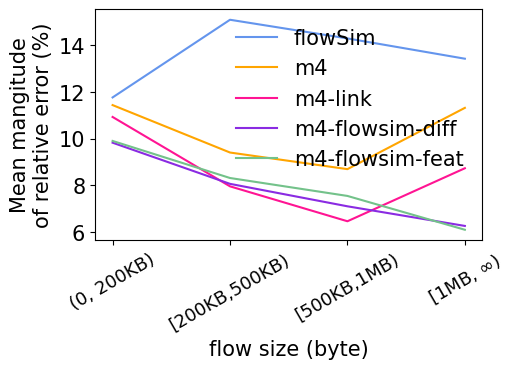

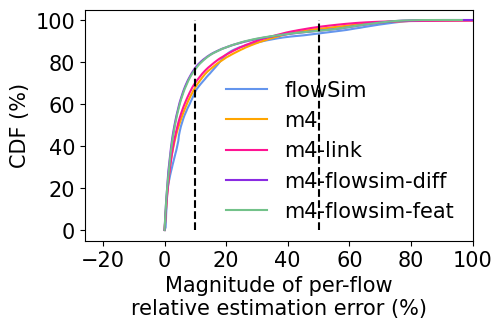

In [15]:
_fontsize=15
for version_id_test in [2]:
    res_total_per_flow=res_total_per_flow_per_data[version_id_test]
    size_total_per_flow=size_total_per_flow_per_data[version_id_test]
    rank_total_per_flow=rank_total_per_flow_per_data[version_id_test]
    len_group_total_per_flow=len_group_total_per_flow_per_data[version_id_test]
    res_total_per_seg=res_total_per_seg_per_data[version_id_test]
                                                 
    enable_debug=False
    # for metric_idx in range(len(metric_label_list)):
    for metric_idx in [1]:
        # relationship between flow size and estimation error
        fsize_total_per_flow=[np.digitize(x, balance_size_bins) for x in size_total_per_flow]
        
        # relationship between flow size and mean/p99 estimation error
        x_total=[]
        for j in range(len(program_name_list)):
            x=[]
            for i in range(len(balance_size_bins_label)):
                tmp=res_total_per_flow[j][fsize_total_per_flow[j]==i]
                x.append([np.mean(tmp),np.percentile(tmp,99), len(tmp)])
            x_total.append(x)
        x_total=np.array(x_total)
        plt.figure(fig_index,figsize=(5, 3))
        # plt.title(f"per-flow on {main_title_list[version_id_test]} set", fontsize="x-large")
        for j in range(len(program_name_list)):
            plt.plot(x_total[j,:,0],label=f"{title_str_list[j]}",color=color_list[j])
            # plt.plot(x_total[j,:,1],label=f"{title_str_list[j]}-99th",color=color_list[j],linestyle='--')
        plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle, fontsize=_fontsize-2)
        plt.legend(loc='upper right',frameon=False, fontsize=_fontsize)
        plt.xlabel("flow size (byte)", fontsize=_fontsize)
        plt.ylabel(f"Mean mangitude\nof relative error (%)", fontsize=_fontsize)
        plt.yticks(fontsize=_fontsize)
        fig_index+=1
        
        plt.figure(fig_index, figsize=(5, 3))
        mean_error_list = []
        # For each program, compute the CDF
        for j in range(len(program_name_list)):
            # Get the estimation error values (res_total_per_flow[j])
            tmp = res_total_per_flow[j]
            
            sorted_errors = np.sort(tmp)
            cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)*100
            
            # Plot the CDF
            plt.plot(sorted_errors, cdf, label=f"{title_str_list[j]}", color=color_list[j])
            mean_error_list.append(np.mean(tmp))
        print(mean_error_list)
        # Set the labels, legend, and font sizes
        plt.legend(loc='lower right', frameon=False, fontsize=_fontsize)
        plt.xlabel("Magnitude of per-flow\nrelative estimation error (%)", fontsize=_fontsize)
        plt.ylabel("CDF (%)", fontsize=_fontsize)
        plt.vlines(x=10, ymin=0, ymax=100, color='k', linestyle='--')
        plt.vlines(x=50, ymin=0, ymax=100, color='k', linestyle='--')
        plt.xlim(right=100)
        # plt.xscale('log')
        plt.xticks(fontsize=_fontsize)
        plt.yticks(fontsize=_fontsize)